# Генеративные модели: автоэнкодеры и GAN

## Генеративный ИИ

**Генеративная модель** — это модель, которая учится описывать распределение данных $p_\text{data}(x)$ и после обучения способна порождать новые объекты, близкие по свойствам к исходным данным. Генеративные подходы различаются по идеологии: одни оптимизируют явную **функцию правдоподобия**, другие строят **состязательные** схемы. Две простые и важные семейства — автоэнкодеры и GAN.

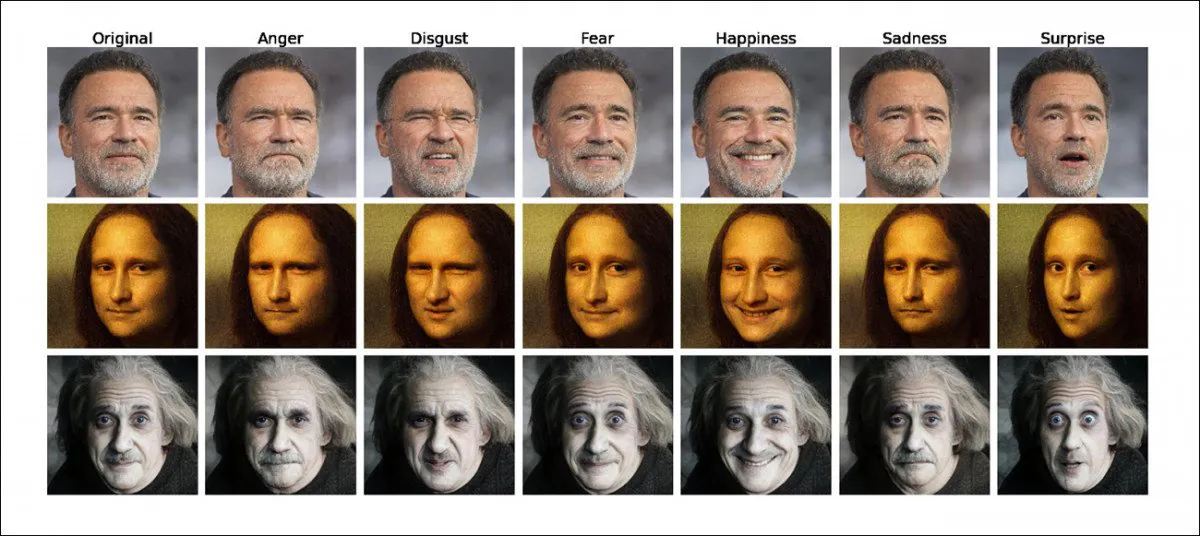

##Автоэнкодеры

###Концепция и формализация

**Автоэнкодер** $(autoencoder,\ AE)$ состоит из двух блоков: **энкодера** $(encoder,\ E)$ и **декодера** $(decoder,\ D)$. Энкодер переводит вход $x$ в представление $z = E(x)$ меньшей размерности, называемое **латентным вектором**. Декодер восстанавливает изображение из латентного вектора $\hat x = D(z)$.

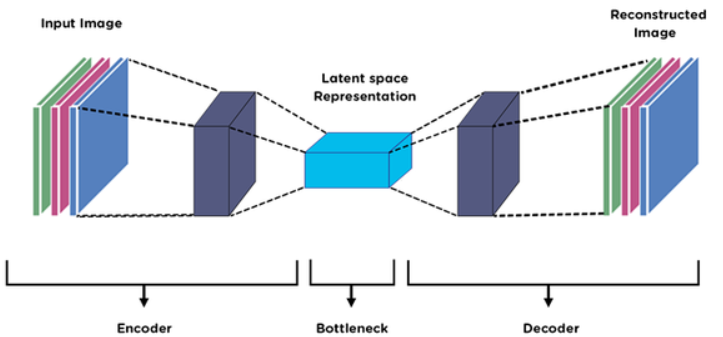

**Обучение** осуществляется путём минимизации функции восстановления, например среднеквадратичной ошибки:

$$L(\theta_E, \theta_D) = \frac{1}{N}\sum_{i=1}^N ||x^{i} - D(E(x^{i}))||_2^2$$

###Примеры применения

На **примере** ниже изображение цифры 7, то есть целое изображение из большого числа пикселей, сжали до компактного представления в виде 32 чисел, то есть латентного вектора, а затем развернули это представление в изображения исходного размера с использованием декодера.

Заметьте, что полученное изображение не содержит **шумов**.  `AE` часто используется для удаления шума или сжатия данных. Но с точки зрения генерации это существенный минус, так как результаты работы `AE` бывают нереалистичны.

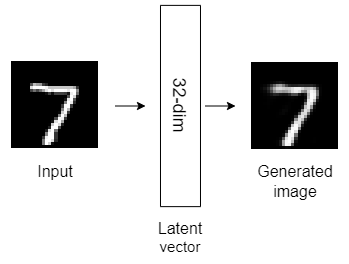

На вход и выход автоэнкодера можно подавать разные представления одного объекта. На **примере** ниже решается следующая задача. На **детектор** прилетают частицы, которые оставляют след в виде небольшого пятна. Частиц конечное количество, поэтому картина получается зашумлённой. Известна аналитическая непрерывная картина. Необходимо по данным с датчика предсказывать аналитический вариант.

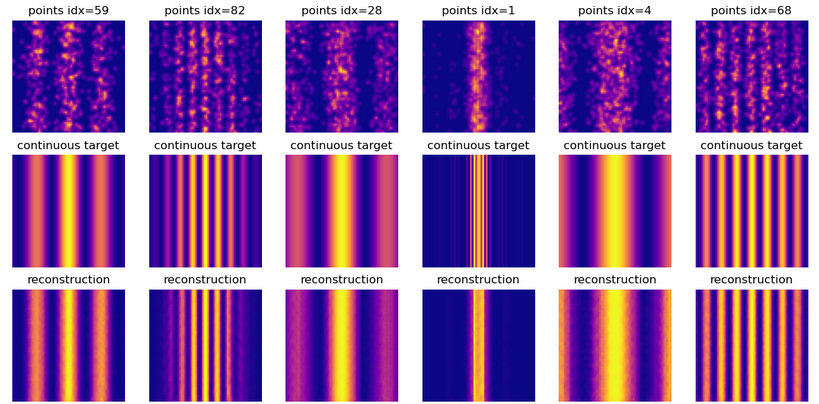

Видим, что энкодер с латентным вектором в 64 числа для изображений `64x64` превосходно справляется с задачей.

### Пример. Генерация изображений с кружочками




####Генерация данных

Создадим набор изображений `32x32` в градациях серого, где на фоне находятся кружки разного радиуса и яркости. После генерации данных реализуем свёрточный автоэнкодер и обучим его.

Импортируем основные библиотеки и зафиксируем рандом.

In [2]:
import numpy as np
from PIL import Image, ImageDraw
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

torch.manual_seed(42)

Сгенерируем данные, 2000 экземпляров.

In [3]:
def make_circle_image(size, radius, cx, cy, intensity, background):
    img = Image.new("L", (size, size), int(255*background))
    draw = ImageDraw.Draw(img)
    bbox = [cx-radius, cy-radius, cx+radius, cy+radius]
    draw.ellipse(bbox, fill=int(255*intensity))
    return np.array(img, dtype=np.float32) / 255.0

def generate_circles(n, size=32, r_min=2, r_max=10):
    X = np.zeros((n, 1, size, size), dtype=np.float32)
    for i in range(n):
        r = np.random.randint(r_min, r_max+1)
        cx = np.random.randint(r, size-r)
        cy = np.random.randint(r, size-r)
        intensity = np.random.uniform(0.3, 1.0)
        bg = np.random.uniform(0.0, 0.1)
        X[i,0] = make_circle_image(size, r, cx, cy, intensity, bg)
    return X

X = generate_circles(2000)
ds = TensorDataset(torch.from_numpy(X))
loader = DataLoader(ds, batch_size=64, shuffle=True)

Выведем несколько примеров.

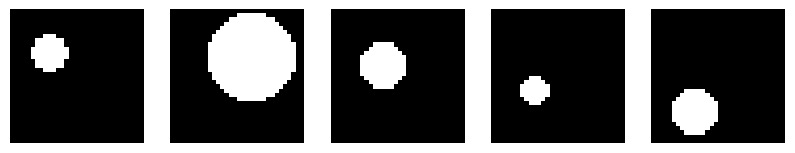

In [8]:
images = [X[i][0] for i in range(5)]

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for ax, img in zip(axes, images):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.show()

####Моделирование

Реализуем свёрточный автоэнкодер. Энкодер принимает на вход одноканальное изображение, применяет 16 фильтров свёртками `3x3`. Затем применяется `ReLU`, 16 каналов обрабатываются в 32 свёртками `3x3`. Результат развернём в латентный вектор небольшой размерности.

In [9]:
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32*8*8, latent_dim)
        )
    def forward(self, x):
        return self.net(x)

Аналогично реализуем декодер, но из **обратных свёрток** $(transpose\ convolution)$, которые позволяют повышать размерность. На иллюстрации ниже пример работы обратной свёртки для перехода от изображения `2x2` к `3x3`.

trans_conv.svg

Для того чтобы границы кружков были чёткими, применяем сигмоиду на выходе.

In [10]:
class ConvDecoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 32 * 8 * 8),
            nn.Unflatten(1, (32, 8, 8)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.net(z)

Инициализируем модели и оптимизатор.

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
enc = ConvEncoder(32).to(device)
dec = ConvDecoder(32).to(device)
opt = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=1e-3)
loss_fn = nn.MSELoss()

Обучим модели.

In [34]:
from tqdm.auto import tqdm

loss_history = []
for epoch in tqdm(range(1, 300)):
    total = 0.0
    for (xb,) in loader:
        xb = xb.to(device)
        z = enc(xb)
        xr = dec(z)
        loss = loss_fn(xr, xb)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total += loss.item() * xb.size(0)

    mean_loss = total / len(X)
    loss_history.append(mean_loss)
    if epoch < 10 or (not (epoch % 10) and 10 < epoch < 100) or \
    (not (epoch % 20) and 100 < epoch < 500):
        print(f"Epoch {epoch}: loss={mean_loss:.6f}")

  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 1: loss=0.135362
Epoch 2: loss=0.060514
Epoch 3: loss=0.048557
Epoch 4: loss=0.033541
Epoch 5: loss=0.019704
Epoch 6: loss=0.014832
Epoch 7: loss=0.013076
Epoch 8: loss=0.011814
Epoch 9: loss=0.010863
Epoch 20: loss=0.006285
Epoch 30: loss=0.005115
Epoch 40: loss=0.004378
Epoch 50: loss=0.003828
Epoch 60: loss=0.003400
Epoch 70: loss=0.003136
Epoch 80: loss=0.002851
Epoch 90: loss=0.002661
Epoch 120: loss=0.002251
Epoch 140: loss=0.002037
Epoch 160: loss=0.001861
Epoch 180: loss=0.001675
Epoch 200: loss=0.001478
Epoch 220: loss=0.001140
Epoch 240: loss=0.000904
Epoch 260: loss=0.000828
Epoch 280: loss=0.000671


####Анализ результатов

Выведем график потерь в ходе обучения в двойном логарифмическом масштабе. Получили хорошую сходимость.

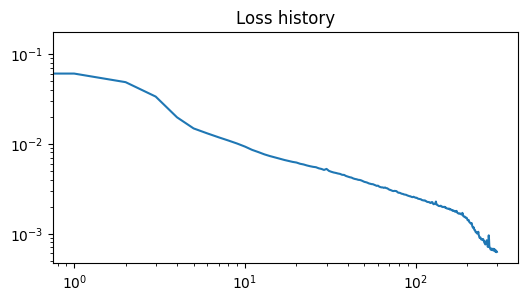

In [36]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.loglog(loss_history)
ax.set_title('Loss history')
plt.show()

Визуализируем несколько исходных изображений и их реконструкций:

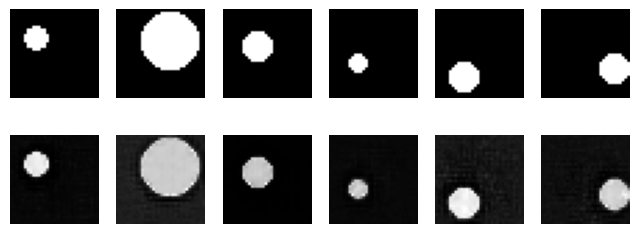

In [37]:
enc.eval()
dec.eval()

with torch.no_grad():
    xb = torch.from_numpy(X[:12]).to(device)
    xr = dec(enc(xb)).cpu().numpy()

plt.figure(figsize=(8,3))
for i in range(6):
    plt.subplot(2,6,i+1)
    plt.imshow(X[i,0], cmap='gray'); plt.axis('off')
    plt.subplot(2,6,6+i+1)
    plt.imshow(xr[i,0], cmap='gray'); plt.axis('off')
plt.show()

## Генеративно-состязательные нейросети (GAN)

###Концепция

Идея **генеративно-состязательных сетей** $(Generative\ Adversarial\ Networks)$ проста и в то же время глубока. Вместо того чтобы напрямую аппроксимировать распределение данных, как это делает автоэнкодер, мы строим две модели, которые соревнуются друг с другом: **генератор**, порождающий изображения из **шума**, и **дискриминатор**, отличающий реальные примеры от сгенерированных.

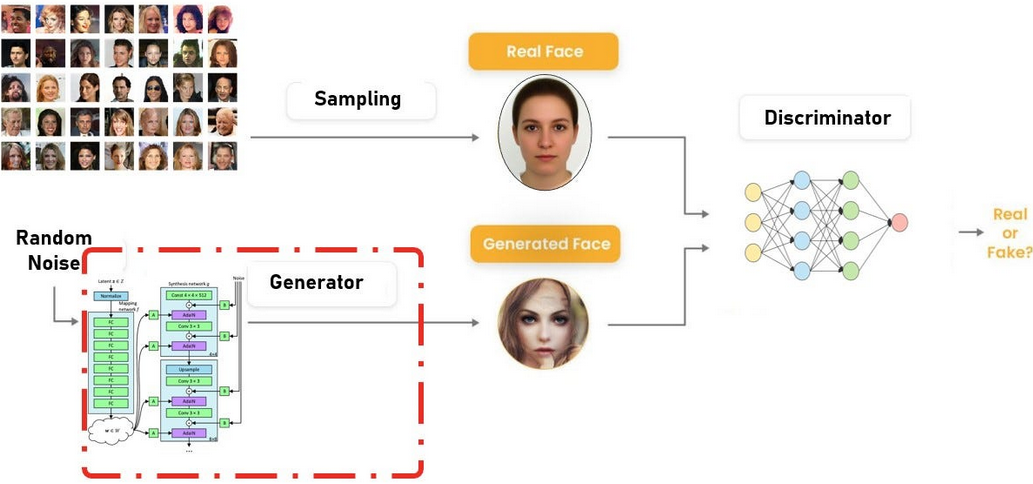

В результате обучения мы получаем **две модели**, причём результаты генератора могут быть значительно реалистичнее, чем выходы декодера в `AE`.

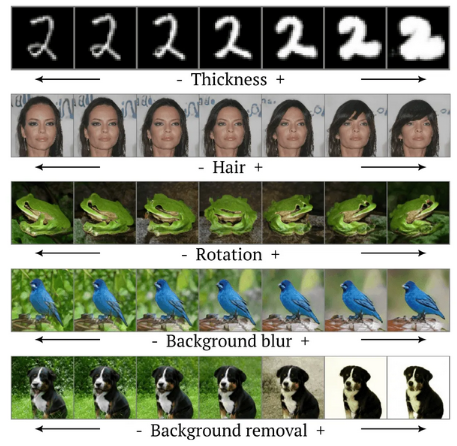

Генератор учится так, чтобы обмануть дискриминатор, а дискриминатор учится всё лучше отличать реальное от ложного, то есть они **состязаются**.

Это представляет собой **сложность**, так как часто либо дискриминатор слишком хорошо различает генерации и реальные объекты, либо генератор даёт слишком реалистиченые результаты. Для решения проблемы стоит вводить регуляризацию, выделять генератору или дискриминатору в отдельности большее число эпох в ходе обучения и т. д.


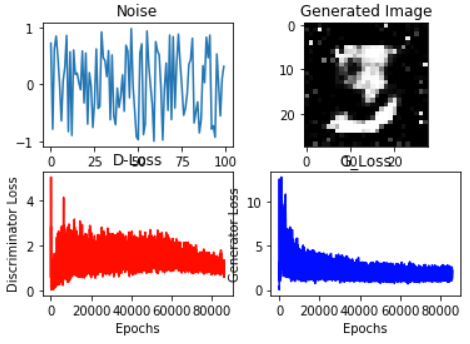

###Формализация

Дискриминатор предсказывает значения близкие к $1$ для настоящего объекта и близкие к $0$ для генерации. **Формально** обучение представляет собой задачу одновременной минимизации функции потерь генератора и максимизации потерь дискриминатора:

$$\min_G \max_D V(D,G) = \mathbb{E}_{x\sim p_{\text{data}}}[\log D(x)] + \mathbb{E}_{z\sim p_z}[\log(1 - D(G(z)))]$$

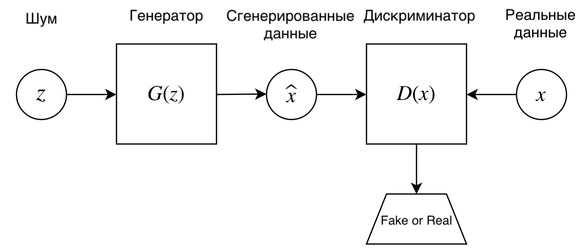

Под **максимизацией** имеется в виду, что значения потерь дискриминатора неположительные. Поэтому, например, потери на дискриминаторе $-0.3$ хуже, чем $-0.01$.

### Пример. Применение GAN к генерации кружков

####Моделирование

Решим **поставленную выше задачу** с использованием `GAN`. Загрузим данные.

In [48]:
dataset = TensorDataset(torch.from_numpy(X))
loader = DataLoader(dataset, batch_size=128, shuffle=True)

Реализуем глубокий свёрточный генератор, который получает на вход набор случайных чисел — шум. На их основе генератор будет отрисовывать изображения.

In [69]:
z_dim = 4

In [51]:
class Generator(nn.Module):
    def __init__(self, zdim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(zdim, 128*8*8),
            nn.ReLU(),
            nn.Unflatten(1, (128,8,8)),
            nn.ConvTranspose2d(128,64,4,2,1),
            nn.ReLU(),
            nn.ConvTranspose2d(64,32,4,2,1),
            nn.ReLU(),
            nn.Conv2d(32,1,3,padding=1),
            nn.Sigmoid()
        )
    def forward(self, z):
        return self.net(z)

Аналогично свёрточный дискриминатор, предсказывающий значение от $0$ до $1$.

In [52]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,32,4,2,1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32,64,4,2,1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(64*8*8, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

Инициализируем модели, оптимизаторы, функцию потерь.

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = Generator(z_dim).to(device)
D = Discriminator().to(device)
optG = torch.optim.Adam(G.parameters(), lr=1e-3, betas=(0.5,0.999))
optD = torch.optim.Adam(D.parameters(), lr=1e-3, betas=(0.5,0.999))
bce = nn.BCELoss()

Обучим модели.

In [71]:
for epoch in tqdm(range(1, 201)):
    for (xb,) in loader:
        xb = xb.to(device)
        bs = xb.size(0)

        # метки 0 и 1 для real и fake
        real = torch.ones(bs,1,device=device)
        fake = torch.zeros(bs,1,device=device)

        # ошибка дискриминатора на real
        out_real = D(xb)
        lossD_real = bce(out_real, real)

        # создаём латентные векторы, генерируем
        # изображения на их основе, считаем ошибку
        # дискриминатора
        z = torch.randn(bs, z_dim, device=device)
        x_fake = G(z)
        out_fake = D(x_fake.detach())
        lossD_fake = bce(out_fake, fake)

        # оптимизируем дискриминатор, чтобы он
        # лучше различал real и fake
        lossD = (lossD_real + lossD_fake) * 0.5
        optD.zero_grad()
        lossD.backward()
        optD.step()

        # аналогично обучаем генератор всё лучше
        # соответствовать real
        z = torch.randn(bs, z_dim, device=device)
        x_fake = G(z)
        out_fake = D(x_fake)
        lossG = bce(out_fake, real)

        optG.zero_grad()
        lossG.backward()
        optG.step()

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch}: D={lossD.item():.4f}, G={lossG.item():.4f}")

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: D=0.3068, G=1.5071
Epoch 10: D=0.9508, G=2.0479
Epoch 20: D=0.3730, G=1.4524
Epoch 30: D=0.4666, G=1.3682
Epoch 40: D=0.6348, G=1.1287
Epoch 50: D=0.6971, G=0.7887
Epoch 60: D=0.5418, G=1.2509
Epoch 70: D=0.5694, G=1.0193
Epoch 80: D=0.5662, G=1.7480
Epoch 90: D=0.5430, G=0.7790
Epoch 100: D=0.6052, G=1.9294
Epoch 110: D=0.6671, G=0.4936
Epoch 120: D=0.6620, G=0.3175
Epoch 130: D=0.5942, G=1.7109
Epoch 140: D=0.6106, G=0.6019
Epoch 150: D=0.7090, G=1.0203
Epoch 160: D=0.6145, G=0.7688
Epoch 170: D=0.6054, G=1.5495
Epoch 180: D=0.5877, G=0.9229
Epoch 190: D=0.6036, G=1.2715
Epoch 200: D=0.7099, G=1.4261


####Анализ результатов

Выведем несколько **примеров**. Видим, что обучение `GAN` нестабильно, результаты в среднем хуже чем у `AE`. Однако `GAN` обаладают лучшей способностью к генерации новых образцов, тогда как `AE` преимущественно способны лишь сжимать уже имеющиеся объекты в латентное представление.

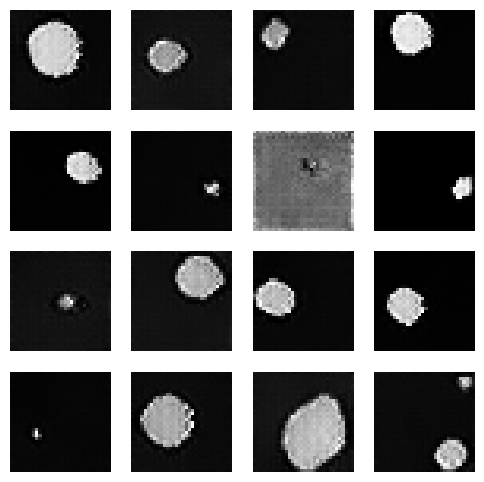

In [72]:
G.eval()
with torch.no_grad():
    z = torch.randn(16,z_dim,device=device)
    samples = G(z).cpu().numpy()
plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(samples[i,0], cmap='gray'); plt.axis('off')
plt.show()


##Выводы

В ходе занятия мы:

1. Познакомились с генеративным ИИ.
2. Изучили концепцию автоэнкодера и формализовали задачу.
3. Привели примеры автоэнкодеров.
4. Реализовали глубокий свёрточный автоэнкодер для работы с изображениями пятен.
5. Познакомились с концепцией `GAN` И формализовали задачу.
6. Реализовали `GAN` для задачи с кружочками.

##Данные об авторе

Зюков Алексей Алексеевич,

лаборант отдела-онлайн образования НИЯУ МИФИ,

бакалавр кафедры суперкомпьютерных технологий в инженерно-физическом моделировании НИЯУ МИФИ.

##Список использованной и рекомендованной литературы

1. Егоров, А. Д. Репозитории с лекциями по анализу данных в НИЯУ МИФИ. – Текст : электронный / А. Д. Егоров // GitHub : [сайт]. – URL: https://github.com/ShadarRim (дата обращения: 01.11.2025).
2. Захаров Е., Волхонский Д. Генеративно-состязательные сети (GAN). – Текст : электронный / Егор Захаров, Волхонский Денис ; Яндекс.Образование. – URL: https://education.yandex.ru/handbook/ml/article/generativno-sostyazatelnye-seti-(gan) (дата обращения: 01.11.2025).
3. Малов, Д. А. Глубокое обучение и анализ данных : практическое руководство. / Д. А. Малов. – Текст : непосредственный. – Санкт-Петербург : БХВ-Петербург, 2023. – 272 с. : ил. – ISBN 978-5-9775-1172-8.

